In [2]:
from arctic import Arctic
from arctic.date import DateRange
from arctic.exceptions import NoDataFoundException
from arctic.date import DateRange
import pandas as pd
import numpy as np
from ib_insync import IB, ContFuture, util, Future, Forex, Contract
from typing import Union
import pickle
from datetime import datetime, timedelta
import sys
sys.path.append('/home/tomek/ib_tools')
from datastore import ArcticStore
from utils import plot
from indicators import get_signals

/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/arctic/store/_pandas_ndarray_store.py:6: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import DataFrame, Series, Panel
/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [50]:
conn = Arctic('localhost')
conn.list_libraries()

['history',
 'MIDPOINT_30_secs',
 'test',
 'TRADES_30_secs',
 'TRADES_1_min',
 'TRADES_1_day',
 'test_log',
 'ver_test',
 'TRADES_1 min',
 'TRADES_30_sec']

In [4]:
log = conn['test_log']

In [44]:
log.list_symbols()

['all_bars_20200715_15_51_ESU0',
 'all_bars_20200715_15_51_GCQ0',
 'all_bars_20200715_15_51_NQU0',
 'all_bars_20200715_15_51_YM   SEP 20',
 'all_bars_20200719_23_16_ESU0',
 'all_bars_20200719_23_16_GCQ0',
 'all_bars_20200719_23_16_NQU0',
 'all_bars_20200719_23_16_YM_SEP_20',
 'all_bars_20200721_21_30_ESU0',
 'all_bars_20200721_21_30_GCQ0',
 'all_bars_20200721_21_30_NQU0',
 'all_bars_20200721_21_30_YM_SEP_20',
 'candles_20200715_15_51_ESU0',
 'candles_20200715_15_51_GCQ0',
 'candles_20200715_15_51_NQU0',
 'candles_20200715_15_51_YM   SEP 20',
 'candles_20200719_23_16_ESU0',
 'candles_20200719_23_16_GCQ0',
 'candles_20200719_23_16_NQU0',
 'candles_20200719_23_16_YM_SEP_20',
 'candles_20200721_21_30_ESU0',
 'candles_20200721_21_30_GCQ0',
 'candles_20200721_21_30_NQU0',
 'candles_20200721_21_30_YM_SEP_20']

In [11]:
df = log.read('candles_20200715_15_51_NQU0').data
#df.drop(['backfill', 'open', 'high', 'low', 'ema_fast', 'ema_slow'], axis=1, inplace=True)

In [12]:
def rsi(price: pd.Series, lookback: int) -> pd.Series:
    df = pd.DataFrame({'price': price})
    df['change'] = df['price'].diff().fillna(0)
    df['up'] = ((df['change'] > 0) * df['change']).rolling(lookback).sum()
    df['down'] = ((df['change'] < 0) * df['change'].abs()).rolling(lookback).sum()
    df['rs'] = df['up'] / df['down']
    df['rsi'] = (100 - (100/(1+df['rs'])))
    return df['rsi']

In [13]:
def modified_rsi(rsi: pd.Series) -> pd.Series:
    return 2*(rsi - 50)

In [14]:
def carver(price: pd.Series, lookback: int) -> pd.Series:
    df = pd.DataFrame({'price': price})
    df['max'] = df['price'].rolling(lookback).max()
    df['min'] = df['price'].rolling(lookback).min()
    df['mid'] = df[['min', 'max']].mean(axis=1)
    df['carver'] = 200*((df['price'] - df['mid']) / (df['max'] - df['min']))
    return df['carver']

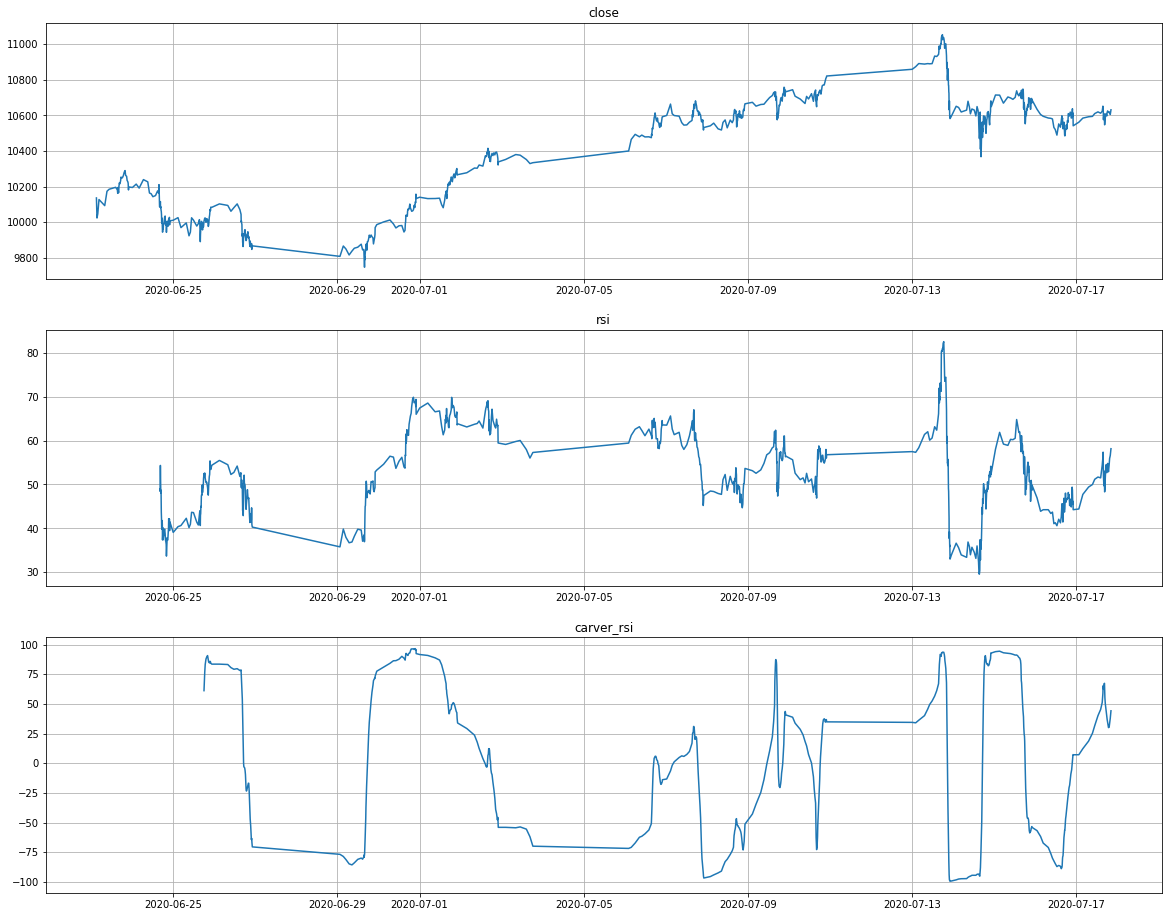

In [15]:
df['rsi'] = rsi(df.price, 50)
df['modified_rsi'] = modified_rsi(df['rsi'])
df['carver_rsi'] = carver(df['rsi'], 50).rolling(15).mean()
plot(df[['close', 'rsi', 'carver_rsi']]);

In [16]:
def range_crosser(ind:pd.Series, threshold: float) -> pd.Series:
    df = pd.DataFrame({'ind': ind})
    df['inside'] = (df['ind'].abs() < threshold) 
    df['ss'] = ~(df['inside'].shift().fillna(False)) & df['inside']
    df['s'] = np.sign(df['ind'].diff())
    df['signal'] = df['ss'] * df['s']
    return df['signal']

In [17]:
df['s'] = range_crosser(df['carver_rsi'], 80)
df['s_filter'] = np.sign(df['price'] - df['ema_fast'])
df['s_filtered_signal'] = df['s'] * ((df['s'] * df['filter']) == 1)

In [35]:
df[(df['s'] != 0)].dropna().tail(50)

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,rsi,modified_rsi,carver_rsi,s,s_filter,s_filtered_signal
date,,,,,,,,,,,,,,,,,,,
2020-06-26 11:29:00,True,10061.00,10087.00,10033.00,10081.50,10081.50,12027,10077.955559,10037.773227,40.350791,0.0,1.0,0.0,52.740456,5.480913,79.147042,-1.0,1.0,-0.0
2020-06-29 13:54:00,True,9859.25,9881.50,9826.00,9876.25,9876.25,12095,9858.016031,9957.167281,39.901659,0.0,-1.0,0.0,39.610225,-20.779549,-79.920835,1.0,1.0,0.0
2020-06-29 15:26:30,True,9844.00,9855.75,9833.25,9846.75,9846.75,12166,9851.146014,9953.320416,39.753949,0.0,-1.0,0.0,38.473440,-23.053120,-78.769929,1.0,-1.0,0.0
2020-07-01 13:50:00,True,10097.75,10108.50,10076.00,10081.00,10081.00,12090,10107.866599,9992.900723,35.387807,0.0,1.0,0.0,61.306043,22.612086,77.708704,-1.0,-1.0,-0.0
2020-07-08 13:37:30,True,10529.50,10574.50,10525.25,10573.50,10573.50,12056,10554.330475,10477.705194,33.022590,0.0,1.0,0.0,51.839550,3.679101,-76.844196,1.0,1.0,1.0
2020-07-09 16:48:00,True,10666.75,10667.75,10639.00,10653.25,10653.25,12377,10680.125859,10573.559144,32.527823,0.0,1.0,0.0,54.936552,9.873104,77.447557,-1.0,-1.0,-0.0
2020-07-13 19:38:00,True,10998.00,11015.00,10995.75,11001.75,11001.75,12222,11001.484963,10798.378935,31.719494,0.0,1.0,0.0,74.404762,48.809524,79.836917,-1.0,1.0,-0.0
2020-07-14 16:06:00,True,10437.50,10458.00,10415.00,10431.25,10431.25,13372,10452.348103,10694.167914,41.243084,0.0,-1.0,0.0,35.232669,-29.534663,-78.275438,1.0,-1.0,0.0
2020-07-15 15:38:00,True,10710.00,10713.75,10685.50,10696.50,10696.50,12870,10709.374697,10643.278880,42.917426,0.0,1.0,0.0,57.456238,14.912475,77.947266,-1.0,-1.0,-0.0


In [42]:
df['repeat'] = df['signal'].rolling(2).mean().round()

In [43]:
df.tail(50)

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,rsi,modified_rsi,carver_rsi,s,s_filter,s_filtered_signal,repeat
date,,,,,,,,,,,,,,,,,,,,
2020-07-16 17:22:00,False,10484.75,10508.50,10478.50,10497.25,10497.25,12332,10503.898795,10613.356830,42.593064,0.0,-1.0,0.0,46.551724,-6.896552,-53.481956,0.0,-1.0,0.0,-0.0
2020-07-16 17:31:00,False,10497.50,10520.75,10490.50,10508.50,10508.50,12795,10505.432530,10611.623650,42.456637,0.0,-1.0,0.0,47.986270,-4.027460,-50.257512,0.0,1.0,0.0,0.0
2020-07-16 17:39:30,False,10508.25,10526.25,10500.50,10521.75,10521.75,12308,10510.871687,10610.138128,42.271980,0.0,-1.0,0.0,48.021953,-3.956094,-46.841140,0.0,1.0,0.0,0.0
2020-07-16 17:52:30,False,10521.75,10529.50,10501.50,10523.00,10523.00,12024,10514.914458,10608.697822,42.114234,0.0,-1.0,0.0,45.958155,-8.083690,-44.486458,0.0,1.0,0.0,0.0
2020-07-16 18:06:30,False,10522.75,10554.25,10516.75,10546.75,10546.75,12297,10525.526305,10607.673886,42.063234,0.0,-1.0,0.0,46.618131,-6.763739,-41.002929,0.0,1.0,0.0,0.0
2020-07-16 18:22:30,False,10546.25,10558.25,10520.25,10523.00,10523.00,12286,10524.684203,10606.274311,42.018324,0.0,-1.0,0.0,46.476235,-7.047530,-36.259081,0.0,-1.0,0.0,0.0
2020-07-16 18:44:30,False,10523.50,10570.75,10523.00,10570.50,10570.50,12455,10539.956136,10605.682998,42.081674,0.0,-1.0,0.0,46.837209,-6.325581,-31.253752,0.0,1.0,0.0,0.0
2020-07-16 19:01:30,False,10570.75,10573.00,10553.75,10560.75,10560.75,12530,10546.887424,10604.940300,41.829322,0.0,-1.0,0.0,46.804555,-6.390890,-28.270486,0.0,1.0,0.0,0.0
2020-07-16 19:14:30,False,10560.50,10610.50,10559.75,10609.75,10609.75,12792,10567.841616,10605.019800,41.927920,0.0,-1.0,0.0,48.165761,-3.668478,-25.517977,0.0,1.0,0.0,0.0


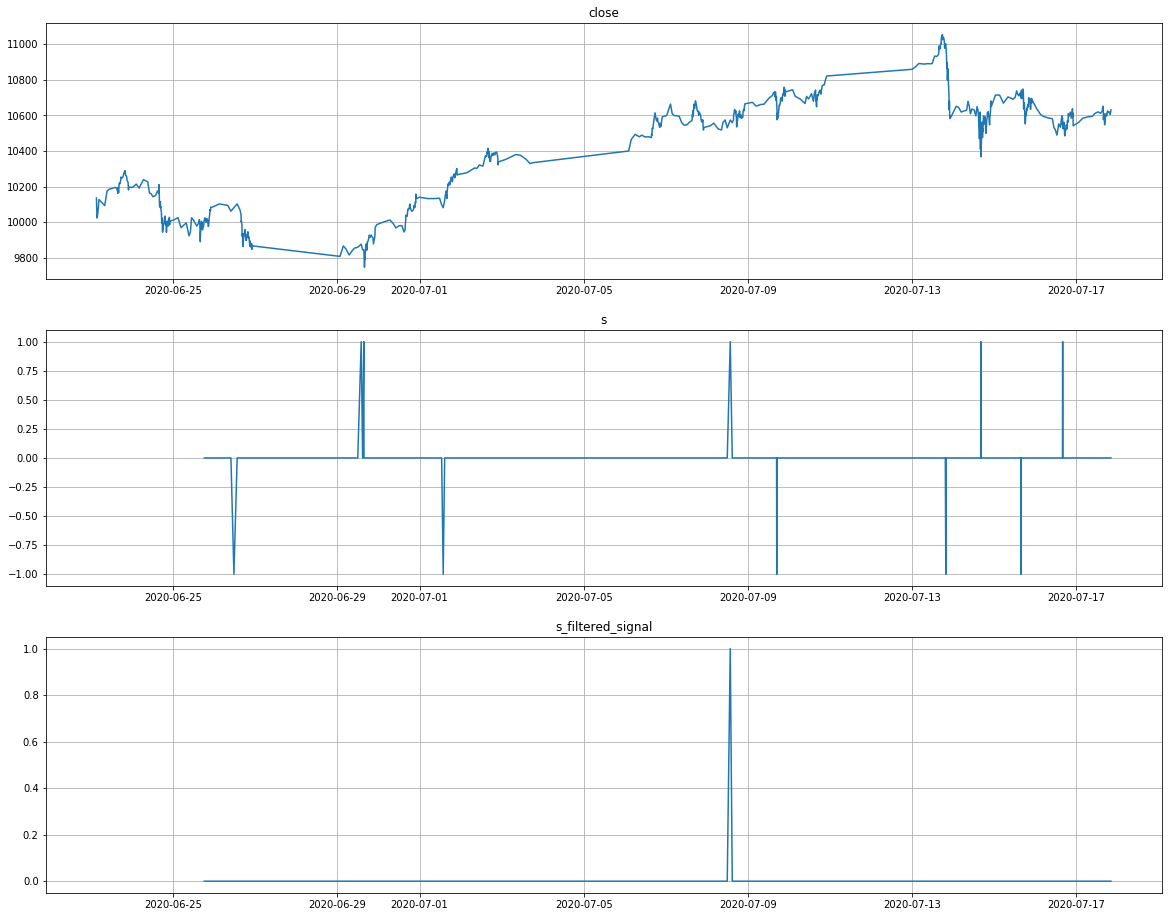

In [18]:
plot(df[['close', 's', 's_filtered_signal']]);

In [36]:
df[df['filter'] != df['s_filter']]

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,rsi,modified_rsi,carver_rsi,s,s_filter,s_filtered_signal
date,,,,,,,,,,,,,,,,,,,
2020-06-23 03:07:00,True,10121.50,10158.25,10115.00,10136.00,10136.00,12018,NaN,NaN,43.250000,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-23 03:27:00,True,10135.75,10137.00,10006.00,10023.25,10023.25,12117,NaN,NaN,87.368750,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-23 03:54:00,True,10022.25,10058.50,9972.25,10046.75,10046.75,12025,10058.118421,NaN,86.991682,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-23 04:37:00,True,10047.50,10135.00,10021.75,10127.00,10127.00,12036,10086.730769,NaN,93.666074,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-23 07:58:00,True,10126.00,10127.50,10088.75,10092.75,10092.75,12005,10089.041469,NaN,82.437440,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-17 15:47:00,False,10621.25,10624.00,10571.50,10575.75,10575.75,12363,10610.155034,10604.866101,40.599437,0.0,1.0,0.0,52.067531,4.135062,62.443524,-0.0,-1.0,-0.0
2020-07-17 16:11:00,False,10592.00,10614.25,10577.25,10608.50,10608.50,12490,10602.786677,10604.503265,40.317824,0.0,-1.0,0.0,53.045551,6.091102,66.843359,0.0,1.0,0.0
2020-07-17 17:07:30,True,10586.75,10608.50,10584.25,10606.75,10606.75,12593,10587.016147,10602.169723,39.953181,0.0,-1.0,0.0,53.587268,7.174537,47.018678,-1.0,1.0,-0.0


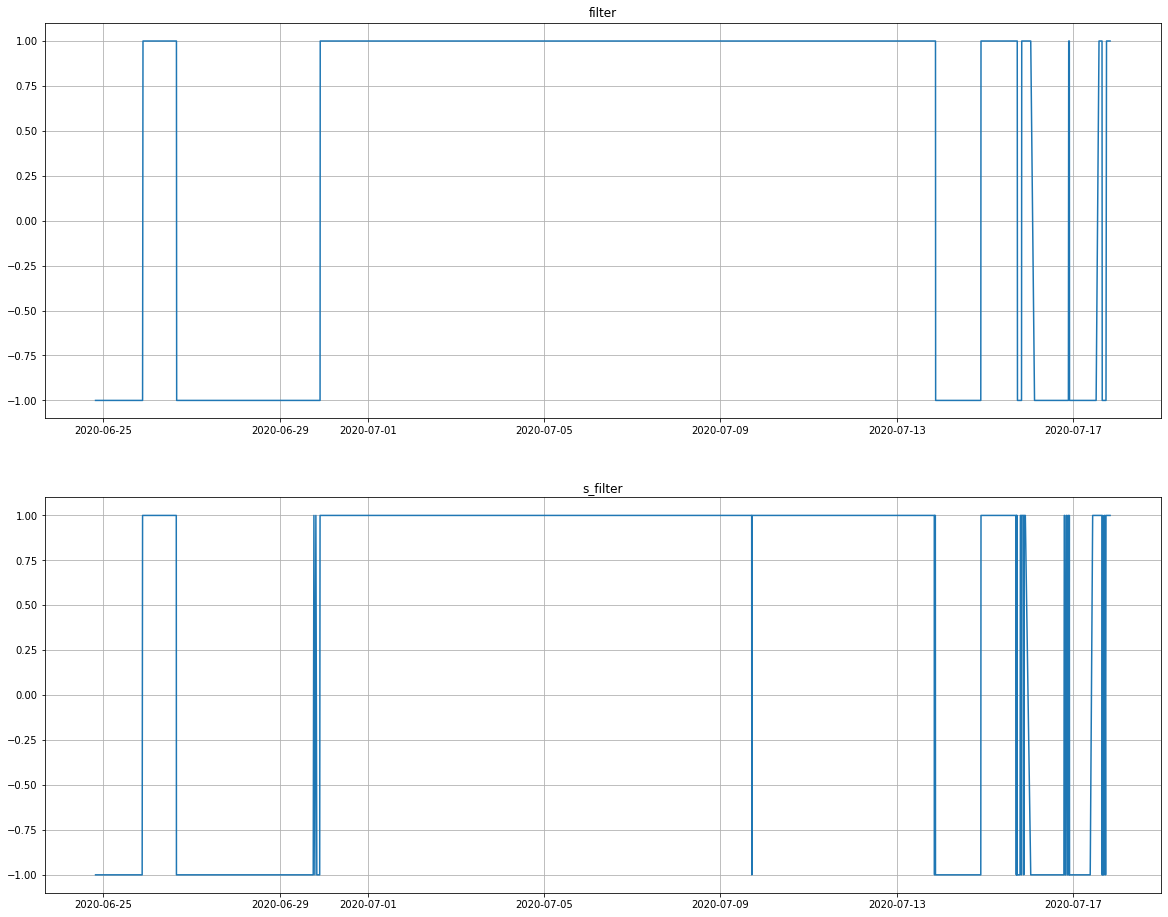

In [37]:
plot(df[['filter', 's_filter']])

In [15]:
df.loc['20200713':].head(50)

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,rsi,modified_rsi,carver_rsi,s
date,,,,,,,,,,,,,,,,,
2020-07-13 00:00:30,True,10820.75,10876.00,10817.50,10858.75,10858.75,12049,10822.689734,10675.046703,32.362444,1.0,1.0,1.0,86.533449,73.066898,37.956302,0.0
2020-07-13 02:01:30,True,10859.50,10909.50,10850.75,10873.50,10873.50,12019,10839.626489,10678.327506,32.654945,1.0,1.0,1.0,84.668645,69.337290,43.219446,0.0
2020-07-13 03:48:30,True,10874.50,10899.75,10858.25,10891.00,10891.00,12036,10856.750993,10681.843370,32.752988,1.0,1.0,1.0,89.124158,78.248316,50.510710,0.0
2020-07-13 07:11:00,True,10891.75,10897.25,10871.00,10888.00,10888.00,12022,10867.167328,10685.251504,32.680908,0.0,1.0,0.0,86.673774,73.347548,57.312097,0.0
2020-07-13 09:05:30,True,10888.00,10917.00,10885.25,10890.75,10890.75,12002,10875.028219,10688.648749,32.670590,0.0,1.0,0.0,87.288136,74.576271,65.995620,0.0
2020-07-13 10:12:00,True,10890.75,10899.25,10878.75,10889.50,10889.50,12104,10879.852146,10691.969157,32.535700,0.0,1.0,0.0,86.828240,73.656481,70.918259,0.0
2020-07-13 11:37:00,True,10889.00,10894.50,10866.00,10890.50,10890.50,12055,10883.401431,10695.251197,32.490973,0.0,1.0,0.0,88.556150,77.112299,77.177062,0.0
2020-07-13 13:07:00,True,10890.75,10934.00,10884.50,10933.00,10933.00,12095,10899.934287,10699.181562,32.679476,1.0,1.0,1.0,90.192484,80.384968,84.069491,0.0
2020-07-13 14:19:30,True,10933.25,10951.75,10924.25,10930.50,10930.50,12125,10910.122858,10703.005613,32.622076,0.0,1.0,0.0,88.695652,77.391304,91.013033,0.0


In [16]:
df['rsi_filtered_signal'] = df['rsi_signal'] * ((df['rsi_signal'] * df['filter']) == 1)
df['p'] = (df['price'] - df['ema_slow']) 

IndentationError: unexpected indent (<ipython-input-16-bde0a106246b>, line 2)

In [ ]:
plot(df[['close', 'rsi_signal', 'p']]);

In [ ]:
df['rsi'].min(), df['rsi'].max()

In [ ]:
df[df['rsi_filtered_signal'] != 0].dropna()

In [ ]:
df[df['rsi_signal'] != 0].dropna()

In [ ]:
df.loc['2020-06-25 07:00:00':].head(10)

In [ ]:
df['mean'] = df['price'].rolling(90).mean()
df['std'] = df['price'].rolling(90).std()
df['diff'] = df['price'] - df['mean']
df['mul'] = df['diff']/df['std']
df['rsi_std_filtered_signal'] = df['rsi_signal'] * ((df['signal'] * df['filter']) == 1)
df

In [ ]:
plot(df[['close', 'mul', 'rsi_signal']]);